# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data",
                                    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\jamr1\\.keras\\datasets\\auto-mpg.data'

Importelo usando pandas.

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()

dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### Limpia los datos

Trata los missings y variables categóricas

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

In [8]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [1]:
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index)

NameError: name 'dataset' is not defined

### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

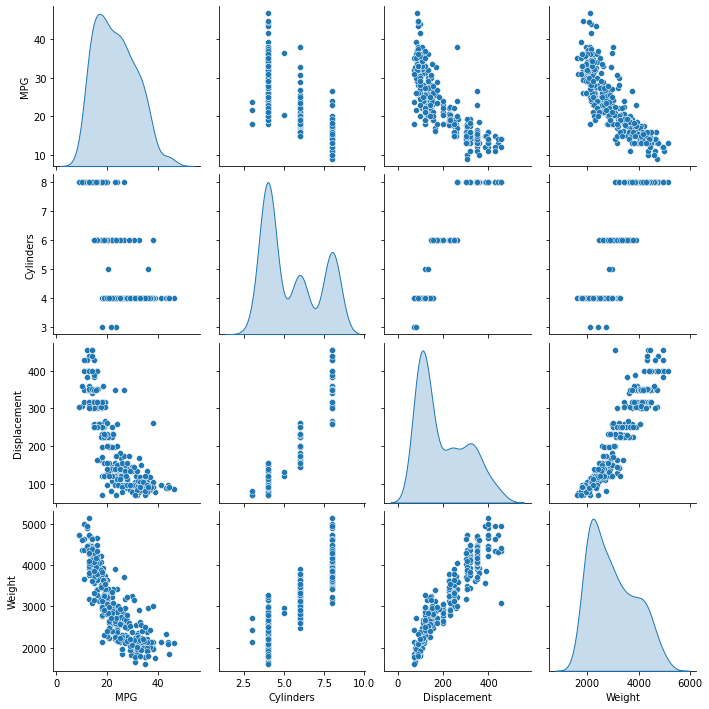

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Tambien revise las estadisticas generales:

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.500000,1.731590,3.0,4.000,4.00,8.0,8.0
Displacement,314.0,196.310510,107.103008,70.0,99.750,151.00,302.0,455.0
Horsepower,314.0,105.242038,39.180324,46.0,75.000,94.50,130.0,225.0
Weight,314.0,2991.229299,874.805321,1613.0,2220.000,2822.50,3670.0,5140.0
Acceleration,314.0,15.503822,2.784195,8.0,13.525,15.45,17.0,24.8
Model Year,314.0,75.894904,3.693329,70.0,73.000,76.00,79.0,82.0
Europe,314.0,0.171975,0.377961,0.0,0.000,0.00,0.0,1.0
Japan,314.0,0.194268,0.396267,0.0,0.000,0.00,0.0,1.0
USA,314.0,0.633758,0.482546,0.0,0.000,1.00,1.0,1.0


### Separa las features del target

Separe el target de las features.

In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [13]:
normed_train_data = (train_dataset - train_stats['mean']) / train_stats['std']
normed_test_data = (test_dataset - train_stats['mean']) / train_stats['std']

Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [16]:
model = keras.Sequential([
                            layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
                        ])

model.compile(loss='mse',
            optimizer = tf.keras.optimizers.RMSprop(0.001),
            metrics=['mae', 'mse'])

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                640       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [24]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

KeyboardInterrupt: 

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,586.094604,22.969446,586.094604,594.710327,22.589457,594.710327,0
1,539.856140,21.944410,539.856140,549.581848,21.561163,549.581848,1
2,493.050873,20.858143,493.050873,500.084259,20.376244,500.084259,2
3,441.564056,19.596537,441.564056,446.147552,19.021570,446.147552,3
4,385.874176,18.174887,385.874176,389.212830,17.495211,389.212830,4


¿Alguna conclusión respecto a este gráfico?

(0.0, 5.0)

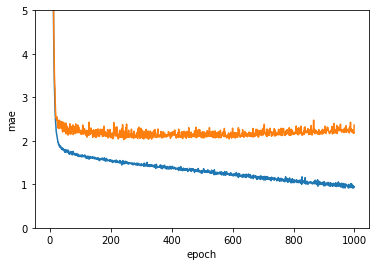

In [23]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.plot(hist['epoch'], hist['mae'],label=['Train Error'])
plt.plot(hist['epoch'], hist['val_mae'],label=['Val Error'])
plt.ylim([0,5])

(0.0, 20.0)

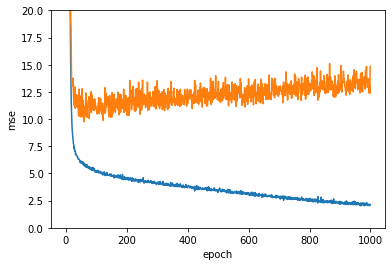

In [25]:
plt.figure()
plt.xlabel('epoch')
plt.ylabel('mse')
plt.plot(hist['epoch'], hist['mse'],label=['Train Error'])
plt.plot(hist['epoch'], hist['val_mse'],label=['Val Error'])
plt.ylim([0,20])

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Después del entrenamiento utiliza la función del apartado anterior `plot_history(history)`.

In [27]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop])

Interpreta el gráfico

TypeError: 'AxesSubplot' object is not subscriptable

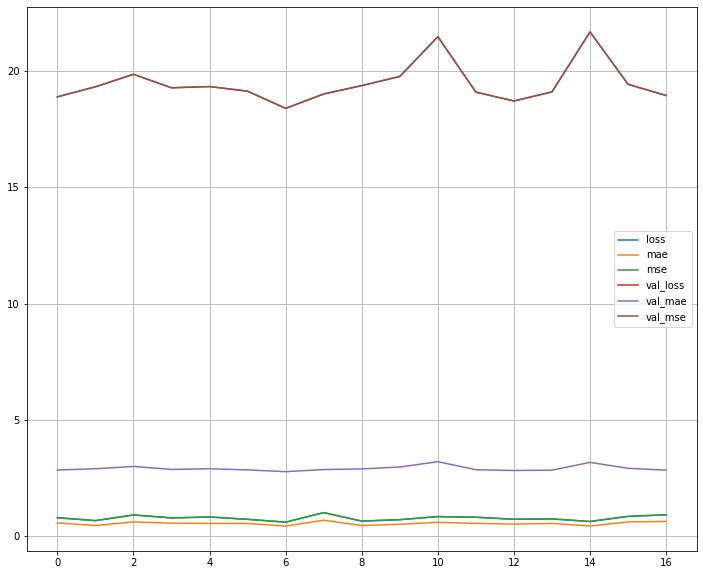

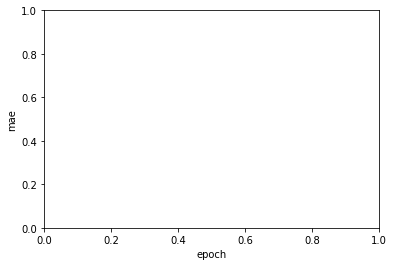

In [29]:
early_history = pd.DataFrame(early_history.history).plot(figsize=(12, 10))
plt.grid(True)
plt.figure()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.plot(early_history['epoch'], early_history['mae'],label=['Train Error'])
plt.plot(early_history['epoch'], early_history['val_mae'],label=['Val Error'])
plt.ylim([0,5])

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

In [31]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))


3/3 [==============================] - 0s 1ms/step - loss: 9.3698 - mae: 2.3307 - mse: 9.3698
Testing set Mean Abs Error:  2.33 MPG


Ahora prueba el modelo. Coge 10 ejemplos de train y llama a` model.predict`.

In [50]:
y_pred = model.predict(normed_train_data[:10])
y_pred

array([[28.244194],
       [23.565256],
       [12.006141],
       [38.103207],
       [35.806957],
       [19.735432],
       [38.03466 ],
       [30.721857],
       [20.41915 ],
       [20.295607]], dtype=float32)

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.